# Project Report: Phase 2

Author: Peter Liu  
Email: pliu27@berkeley.edu

``Objective``

The object of this notebook is to establish create several models to predict churn.
- Method to upsample the minority class.
- Method to tune and save model configurations.
- Method to evaluate best tuned models on test split.
- Method to perform PCA on embeddings and graphs.
- Method to perform Subgroup analysis.

1. Baseline
1. Random Forest
1. Logistic Regression
1. Embedding





### Imports and Functions

Library Versions

<pre>
numpy: 1.26.4
pandas: 2.2.3
tensorflow: 2.15.0
matplotlib: 3.10.0
sklearn: 1.6.1
plotly: 6.0.1
tensorflow_datasets: 4.9.8
wordcloud: 1.9.4
bigquery: 3.34.0
</pre>

In [ ]:
# imports libraries, turn off warnings, define BigQuery key

import os
import pickle
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as plotly

from IPython.display import Image
from collections import Counter

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Reshape

from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

from wordcloud import WordCloud
from google.cloud import bigquery

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

%matplotlib inline


#### Imbalance Functions


In [2]:
# rebalance - upsample minority class and downsample majority class


def dataset_rebalance(X, y, label, ratio = .5):
    df_train = pd.concat([X, y], axis=1)

    class_0 = df_train[df_train[label] == 0]
    class_1 = df_train[df_train[label] == 1]


    total = len(df_train)
    half = int(total * (1-ratio))

    class_0_bal = class_0.sample(n=half, replace=len(class_0) < half, random_state=1)
    class_1_bal = class_1.sample(n=total - half, replace=len(class_1) < (total - half), random_state=1)

    df_balanced = pd.concat([class_0_bal, class_1_bal]).reset_index(drop=True)

    X = df_balanced.drop(columns=[label])
    y = df_balanced[label]
    return X, y


### Load Datasets and Global Constants

In [3]:
# read in train and val datasets

embedding_cols = ['productName', 'productSKU']
target_col = 'session_convert'

X_train = pd.read_csv('../data/X_train.csv', index_col=False)
y_train = pd.read_csv('../data/y_train.csv', index_col=False)[target_col]

X_val = pd.read_csv('../data/X_val.csv', index_col=False)
y_val = pd.read_csv('../data/y_val.csv', index_col=False)[target_col]


### Examine the imbalance


In [4]:

neg, pos = np.bincount(y_train)
total = neg + pos
print('Dataset:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Dataset:
    Total: 461483
    Positive: 11552 (2.50% of total)



### Degree of Imbalance

% of data belonging to minority class | Degree of imbalance
-|-
20-40% | Mild
1-20% | Moderate
<1%   | Extreme


#### Imbalance Ratio and Class Weight

In [5]:

# tune the imbalance ratio to raise minority class samples
# i.e. 0.5 indicates 50% equal pos and neg classes

imbalance_ratio = 0.15

X_train, y_train = dataset_rebalance(X_train, y_train, target_col, imbalance_ratio)

neg, pos = np.bincount(y_train)
total = neg + pos
print('Rebalance:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))


Rebalance:
    Total: 461483
    Positive: 69223 (15.00% of total)



In [6]:
# prepare embedding dataset

subsamples = 20000
random_state = 1

df = pd.concat([X_train, y_train], axis=1)
df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)
X_train = df.drop(columns=target_col)
y_train = df[target_col]

X_train_embed = pd.DataFrame()
X_train_embed['productName'] = X_train['productName'] # [0:subsamples]
y_train_embed = y_train # [0:subsamples]

X_val_embed = pd.DataFrame()
X_val_embed['productName'] = X_val['productName']
y_val_embed = y_val

X_train = X_train.drop(columns=embedding_cols)
X_val = X_val.drop(columns=embedding_cols)


In [7]:
try:
    tokenizer = tfds.features.text.Tokenizer()
except AttributeError:
    tokenizer = tfds.deprecated.text.Tokenizer()

# create an instance of the Counter class
token_counts = Counter()
for productName in X_train_embed['productName']:
    tokens = tokenizer.tokenize(productName)
    token_counts.update(tokens)

train_vocab = []
for token in token_counts.keys():
    train_vocab.append(token)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

def show_history(hist):
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['accuracy'], '-o', label='Train')
    ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    ax.set_ylim(0,1)
    plt.show()


def encode_only(X, y, input_len, batch_size):
    # TODO

    try:
        encoder = tfds.features.text.TokenTextEncoder(token_counts) # token_counts contains our training vocabulary
    except AttributeError:
        encoder = tfds.deprecated.text.TokenTextEncoder(token_counts)

    def encode(text_tensor, label):
        text = text_tensor.numpy()[0]
        encoded_text = encoder.encode(text)
        return encoded_text[:input_len], label

    #  wrap the encode function to a TF Operator
    def encode_map_fn(text, label):
        return tf.py_function(encode, inp=[text, label],
                            Tout=(tf.int64, tf.int64))

    data_embedding = tf.data.Dataset.from_tensor_slices(
        (X[['productName']].values, y.values)
    )
    return data_embedding.map(encode_map_fn).padded_batch(
        batch_size,
        padded_shapes=([-1],[])
    )

def encode_and_batch(X, y, input_len, batch_size):
    # create an instance of the TF encoder class

    try:
        encoder = tfds.features.text.TokenTextEncoder(token_counts) # token_counts contains our training vocabulary
    except AttributeError:
        encoder = tfds.deprecated.text.TokenTextEncoder(token_counts)

    def encode(text_tensor, label):
        text = text_tensor.numpy()[0]
        encoded_text = encoder.encode(text)
        return encoded_text[:input_len], label

    #  wrap the encode function to a TF Operator
    def encode_map_fn(text, label):
        return tf.py_function(encode, inp=[text, label],
                            Tout=(tf.int64, tf.int64))

    data_embedding = tf.data.Dataset.from_tensor_slices(
        (X[['productName']].values, y.values)
    )
    return data_embedding.map(encode_map_fn).padded_batch(
        batch_size,
        padded_shapes=([-1],[])
    )


In [8]:
len(token_counts)

554

### Model 1 - Baseline 1

Always predicts 0 (no churn)

In [9]:
def majority_baseline(x):
    return 0

class Model1:
    def fit(self, X, y):
        return
    def predict(self, X):
        return X.apply(majority_baseline, axis=1)
    def accuracy(self, X, y):
        return np.sum(y_val == self.predict(X)) / len(y)

model1 = Model1()
model1_accuracy = model1.accuracy(X_val, y_val)


# model1_pred = X_val.apply(majority_baseline, axis=1)
# model1_accuracy = np.sum(y_val == model1_pred) / len(y_val)
print(model1_accuracy)

0.974972100935025


### Model 2 - Single Decision Tree

0.9381236659913107


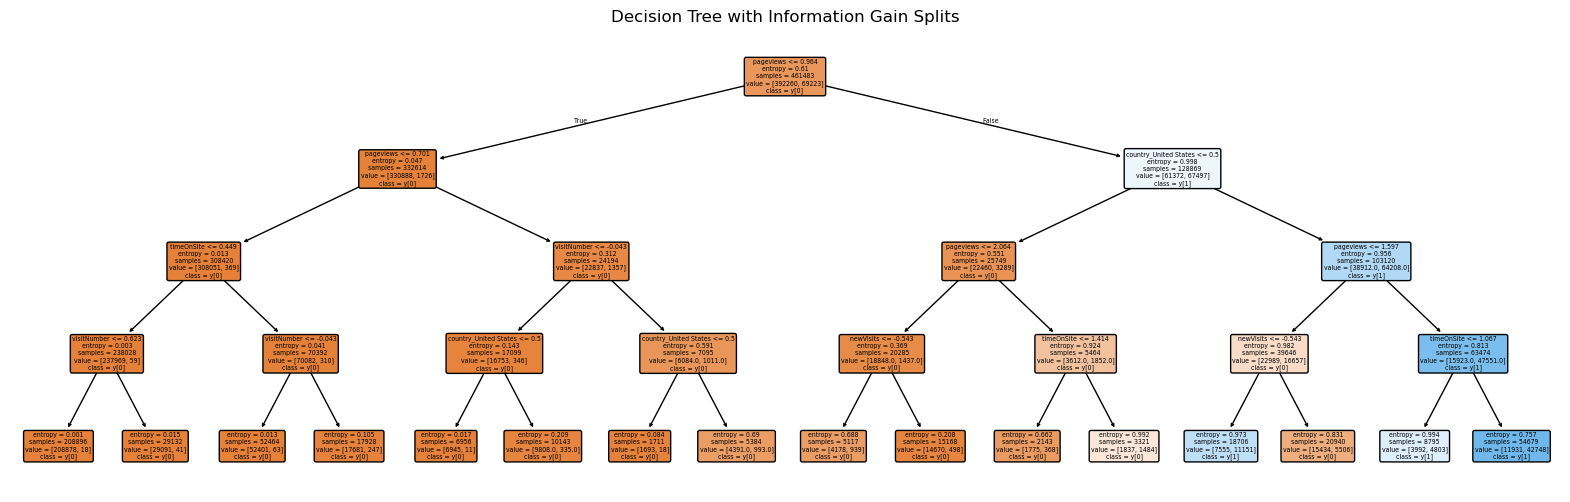

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [10]:
# 0.8722493688852292 weighted
# 0.9381236659913107 non-weighted
def model2_dt_tune():
    model2 = DecisionTreeClassifier(criterion='entropy', max_depth=4)
    model2.fit(X_train, y_train)
    model2_accuracy = model2.score(X_val, y_val)
    print(model2_accuracy)

    plt.figure(figsize=(20, 6))
    plot_tree(model2, feature_names=X_train.columns, class_names=True, filled=True, rounded=True)
    plt.title("Decision Tree with Information Gain Splits")
    plt.show()
    return model2

model2_dt_tune()

### Model 2 - Random Forest

In [11]:
# non-weighted 0.9512660216475075
# weighted 0.901377348126158
def model2_random_forest_tune():
    X = X_train.copy()
    y = y_train.copy()
    model2 = RandomForestClassifier(n_estimators=30,
                                        n_jobs=-1,
                                        random_state=7,
                                        max_depth=8,
                                        verbose = 0,
                                        )
    model2.fit(X_train, y_train)

    model2_accuracy = model2.score(X_val, y_val)
    print(model2_accuracy)

model2_random_forest_tune()

0.9512660216475075


### Model 2 - Random Forest (Tuned)

In [12]:
# random forest tuning
# 0.90484 - non tuned
# 0.99181 - 64/64 non-weighted
# 0.99177 - 64/64 weighted

def model2_tune():
    for n_estimators, max_depth in [
        # (8, 8),
        # (16, 16),
        # (32, 32),
        # (128, 64),
        # (64, 128),
        (64, 64),
        ]:
        model2 = RandomForestClassifier(n_estimators=n_estimators,
                                            n_jobs=-1,
                                            random_state=7,
                                            max_depth=max_depth,
                                            verbose = 0
                                            )
        model2.fit(X_train, y_train)
        model2_accuracy = model2.score(X_val, y_val)
        print('estimators:', n_estimators, 'max depth:', max_depth, 'accuracy:', round(model2_accuracy, 5))

model2_tune()

estimators: 64 max depth: 64 accuracy: 0.99181


### Model 3 - Neural Network

In [13]:
# 0.9485248923301697 - non-weighted

model3_epochs = 10
model3_batch_size = 512

def build_model3_shallow():

    model = Sequential([
        Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(1, activation='sigmoid')  # Output layer for regression
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])
    return model

# Train the model

def model3_shallow_tune():
    model3 = build_model3_shallow()
    model3_history = model3.fit(X_train,
                        y_train,
                        validation_data=(X_val, y_val),
                        epochs=model3_epochs,
                        batch_size=model3_batch_size,
                        callbacks = [early_stopping],
                        verbose=1)

    model3_accuracy = model3_history.history['val_accuracy'][-1]
    print(model3_accuracy)

# model3_shallow_tune()

### Model 3 - Neural Network (Hidden Layers)

In [14]:

model3_batch_size = 1024 * 2
model3_learning_rate = 1e-2
model3_epochs = 10

def build_model3():
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])


    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=model3_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])
    return model


In [15]:
def model3_tune():
    model3 = build_model3()
    model3_history = model3.fit(X_train,
                        y_train,
                        validation_data=(X_val, y_val),
                        epochs=model3_epochs,
                        batch_size=model3_batch_size,
                        callbacks = [early_stopping],
                        verbose=1)

    model3_accuracy = model3_history.history['val_accuracy'][-1]
    print(model3_accuracy)


### Model 4 - Embedding Model

In [16]:

model4_tuning_params = [

    [100, 5, 1e-1, 1024],
    [100, 10, 1e-2, 1024],
    [200, 10, 1e-2, 1024],
    [500, 10, 1e-1, 1024],
    [500, 10, 1e-2, 1024],
    [500, 10, 1e-3, 1024],
    [500, 15, 1e-2, 1024],
    [1000, 10, 1e-2, 1024],
    [1000, 15, 1e-2, 1024],
    [500, 20, 1e-2, 1024],

]

def build_model4(input_len, embeddings_dim, learning_rate):
    vocab_size_train = len(token_counts) + 2

    model = tf.keras.Sequential()
    # add embedding layer (this is our imput layer)
    # embeddings will be learned during training
    # the weights for the embeddings are randomly initialized (just like any other layer!)
    model.add(Embedding(
        vocab_size_train,
        embeddings_dim,
        input_length=input_len, #limits length of sentence to xxx tokens
        name="embedding"))


    # architecture 1
    model.add(Dropout(0.3))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.build(input_shape=(None, input_len))  # Set batch size as None (flexible), sequence length = input_len

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy'])

    return model

In [17]:
# set random seed to get reproductible results
# neural network algorithms are stochastic (e.g., due to random weight initialization); setting a random seed helps to get more stable results after each run
# however, best way to deal with randomness is to repeat your experiment many times (30+) and use statistics to summarize the performance of the model
tf.random.set_seed(1)
np.random.seed(1)

# max_length - max number of words in product names
# embeddings_dim

history = []
weights = []

# tuning parameters
model4 = None
def model4_tune_and_save():
    for input_len, embedding_dim, learning_rate, batch_size in model4_tuning_params:
        print('input_len', input_len, 'embedding_dim', embedding_dim, 'learning_rate', learning_rate, 'batch_size', batch_size)
        model4 = build_model4(input_len=input_len, embeddings_dim=embedding_dim, learning_rate=learning_rate)
        model4_history = model4.fit(
            encode_and_batch(X_train_embed, y_train_embed, input_len, batch_size),
            validation_data=encode_and_batch(X_val_embed, y_val_embed, input_len, batch_size),
            epochs=10,
            callbacks = [early_stopping],
            verbose=1)
        history.append(model4_history.history)
        weights.append(model4.get_layer('embedding').get_weights()[0])
        model4.save(f'model4_{input_len}_{embedding_dim}_{learning_rate}_{batch_size}')
    show_history(history[0])
# model4_tune_and_save()

In [18]:
# save the model
# 82m 1.0s
# model4.save(f'model4_{input_len}_{embedding_dim}_{learning_rate}_{batch_size}')


In [19]:
# saving model4 history for later plotting

# Save to file
# [500, 10, 1e-2, 1024],
# [500, 15, 1e-2, 1024],
# [500, 20, 1e-2, 1024],
# with open('model4_param4_weights_history.pkl', 'wb') as f:
#     pickle.dump(history, f)

In [20]:
# model4_accuracy = model4_history.history['val_accuracy'][-1]
# show_history(history[0])

# Model Evaluation

In [21]:
# test set

X_test_init = pd.read_csv('../data/X_test.csv', index_col=False)
y_test_init = pd.read_csv('../data/y_test.csv', index_col=False)

X_test = X_test_init.drop(columns=embedding_cols)
y_test = y_test_init[target_col]

X_test_embed = pd.DataFrame()
X_test_embed['productName'] = X_test_init['productName']
y_test_embed = y_test_init[target_col]

print('X_test.shape', X_test.shape)
print('y_test.shape', y_test.shape)


X_test.shape (92297, 33)
y_test.shape (92297,)


### Validation and Test accuracy

In [22]:
def print_val_test_acc(name, y, y_pred):
    outcome_class = '1'
    y_outcome = (y_pred > 0.5).astype(int)
    report = classification_report(y, y_outcome, output_dict=True)
    print(f"{name} | {outcome_class} | {report[outcome_class]['precision']:.3f} | {report[outcome_class]['recall']:.3f} | {report[outcome_class]['f1-score']:.3f} | {report[outcome_class]['support']:.0f} ")
    # outcome_class = '1'
    # print(f"{' |' * (len(name.split('|'))-1)} | {outcome_class} | {report[outcome_class]['precision']:.3f} | {report[outcome_class]['recall']:.3f} | {report[outcome_class]['f1-score']:.3f} | {report[outcome_class]['support']:.0f} ")


Decision Tree | 4 | 100 | 1 | 0.267 | 0.846 | 0.406 | 2310 
Random Forest | 8 | 8 | 1 | 0.311 | 0.820 | 0.451 | 2310 
Random Forest | 16 | 16 | 1 | 0.353 | 0.907 | 0.508 | 2310 
Random Forest | 32 | 32 | 1 | 0.690 | 0.996 | 0.815 | 2310 
Random Forest | 128 | 64 | 1 | 0.754 | 0.996 | 0.859 | 2310 
Random Forest | 64 | 128 | 1 | 0.755 | 0.996 | 0.859 | 2310 
Random Forest | 64 | 64 | 1 | 0.755 | 0.996 | 0.859 | 2310 


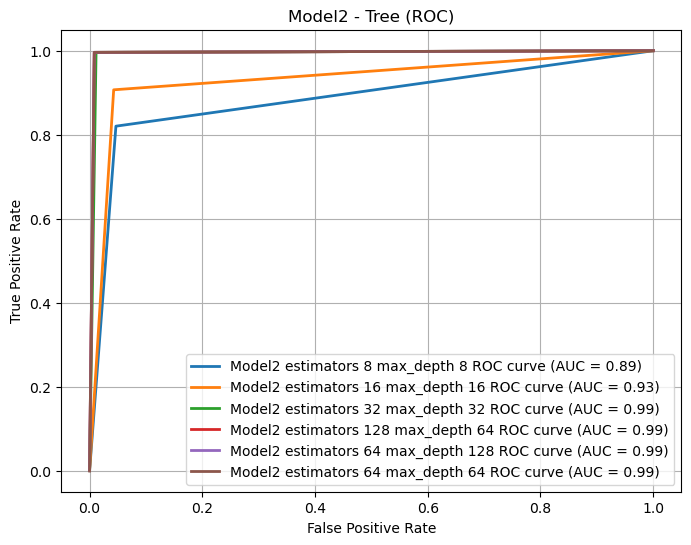

In [23]:
model2 = DecisionTreeClassifier(criterion='entropy', max_depth=4)
model2.fit(X_train, y_train)
print_val_test_acc('Decision Tree | 4 | 100', y_val, model2.predict(X_val))

plt.figure(figsize=(8, 6))
for n_estimators, max_depth in [
    (8, 8),
    (16, 16),
    (32, 32),
    (128, 64),
    (64, 128),
    (64, 64), # best model
    ]:
    model2 = RandomForestClassifier(n_estimators=n_estimators,
                                        n_jobs=-1,
                                        random_state=7,
                                        max_depth=max_depth,
                                        verbose = 0)
    model2.fit(X_train, y_train)
    model2_pred = model2.predict(X_val)
    print_val_test_acc(f"Random Forest | {n_estimators} | {max_depth}", y_val, model2_pred)
    fpr, tpr, thresholds = roc_curve(y_val, model2_pred.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Model2 estimators {n_estimators} max_depth {max_depth} ROC curve (AUC = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model2 - Tree (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


I0000 00:00:1754139791.846915  302970 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2885/2885 [==============================] - 2s 744us/step
Model3 | Shallow Neural Network | 561 | 1 | 0.301 | 0.839 | 0.443 | 2310 
2885/2885 [==============================] - 2s 844us/step
Model3 | Deep Neural Network | 1633 | 1 | 0.305 | 0.841 | 0.447 | 2310 


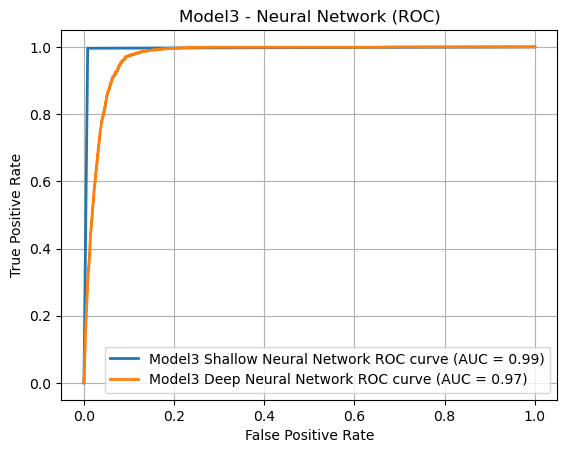

In [24]:
model3 = build_model3_shallow()
model3.fit(X_train,
           y_train,
           verbose=0)
model3_pred = model3.predict(X_val, verbose=1)
print_val_test_acc(f"Model3 | Shallow Neural Network | {model3.count_params()}", y_val, model3_pred)

fpr, tpr, thresholds = roc_curve(y_val, model2_pred.ravel())
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'Model3 Shallow Neural Network ROC curve (AUC = {roc_auc:.2f})')

# best model
model3 = build_model3()
model3.fit(X_train,
           y_train,
           verbose=0)
model3_pred = model3.predict(X_val, verbose=1)
print_val_test_acc(f"Model3 | Deep Neural Network | {model3.count_params()}", y_val, model3_pred)

fpr, tpr, thresholds = roc_curve(y_val, model3_pred.ravel())
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'Model3 Deep Neural Network ROC curve (AUC = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model3 - Neural Network (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


DNN Embeddings | 8714 | 100 | 5 | 0.1 | 1024 | 1 | 0.025 | 1.000 | 0.049 | 2310 
DNN Embeddings | 13049 | 100 | 10 | 0.01 | 1024 | 1 | 0.140 | 0.645 | 0.230 | 2310 
DNN Embeddings | 13049 | 200 | 10 | 0.01 | 1024 | 1 | 0.193 | 0.399 | 0.260 | 2310 
DNN Embeddings | 13049 | 500 | 10 | 0.1 | 1024 | 1 | 0.433 | 0.188 | 0.262 | 2310 
DNN Embeddings | 13049 | 500 | 10 | 0.01 | 1024 | 1 | 0.472 | 0.186 | 0.267 | 2310 
DNN Embeddings | 13049 | 500 | 10 | 0.001 | 1024 | 1 | 0.529 | 0.098 | 0.165 | 2310 
DNN Embeddings | 17429 | 500 | 15 | 0.01 | 1024 | 1 | 0.412 | 0.193 | 0.263 | 2310 
DNN Embeddings | 13049 | 1000 | 10 | 0.01 | 1024 | 1 | 0.667 | 0.066 | 0.120 | 2310 
DNN Embeddings | 17564 | 1000 | 15 | 0.01 | 1024 | 1 | 0.025 | 1.000 | 0.049 | 2310 
DNN Embeddings | 21809 | 500 | 20 | 0.01 | 1024 | 1 | 0.411 | 0.205 | 0.274 | 2310 


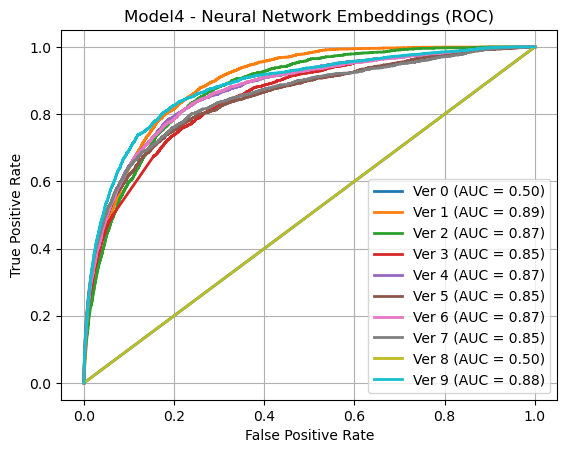

In [34]:
for idx, tuning_params in enumerate(model4_tuning_params):
    input_len, embedding_dim, learning_rate, batch_size = tuning_params
    model_file = f'model4_{input_len}_{embedding_dim}_{learning_rate}_{batch_size}'
    model4 = load_model(model_file)
    X_val_batch = encode_and_batch(X_val_embed, y_test, input_len, batch_size)
    model4_pred = model4.predict(X_val_batch, verbose=0)
    print_val_test_acc(f"DNN Embeddings | {model4.count_params()} | {input_len} | {embedding_dim} | {learning_rate} | {batch_size}", y_val_embed, model4_pred)
    fpr, tpr, thresholds = roc_curve(y_val, model4_pred.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Ver {idx} (AUC = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model4 - Neural Network Embeddings (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### PCA

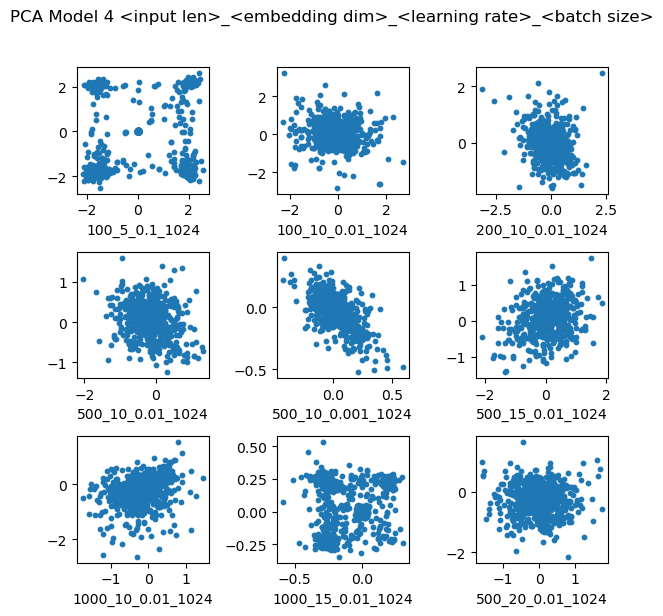

In [33]:

fig, axes = plt.subplots(3, 3, figsize=(6, 6))  # 4x4 grid
ax = axes.flatten()

for idx, tuning_params in enumerate([
    [100, 5, 1e-1, 1024],
    [100, 10, 1e-2, 1024],
    [200, 10, 1e-2, 1024],
    [500, 10, 1e-2, 1024],
    [500, 10, 1e-3, 1024],
    [500, 15, 1e-2, 1024],
    [1000, 10, 1e-2, 1024],
    [1000, 15, 1e-2, 1024],
    [500, 20, 1e-2, 1024]]):
    input_len, embedding_dim, learning_rate, batch_size = tuning_params
    model_file = f'model4_{input_len}_{embedding_dim}_{learning_rate}_{batch_size}'
    model = load_model(model_file)
    embeddings = model.get_layer('embedding').get_weights()[0]
    x1 = embeddings[:, 0]
    x2 = embeddings[:, 1]
    ax[idx].scatter(x1, x2, s=10)
    ax[idx].set_xlabel(f'{input_len}_{embedding_dim}_{learning_rate}_{batch_size}', fontsize=10)
    # model_pred = model.predict(encode_and_batch(X_test_embed, y_test, input_len, batch_size))


plt.suptitle("PCA Model 4 <input len>_<embedding dim>_<learning rate>_<batch size>", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()


### ROC Best Models

Random Forest | 1 | 0.757 | 0.998 | 0.861 | 2311 
2885/2885 [==============================] - 6s 2ms/step
Logistic NN | 1 | 0.295 | 0.849 | 0.438 | 2311 
91/91 [==============================] - 94s 1s/step
Emb. CNN | 1 | 0.438 | 0.206 | 0.280 | 2311 


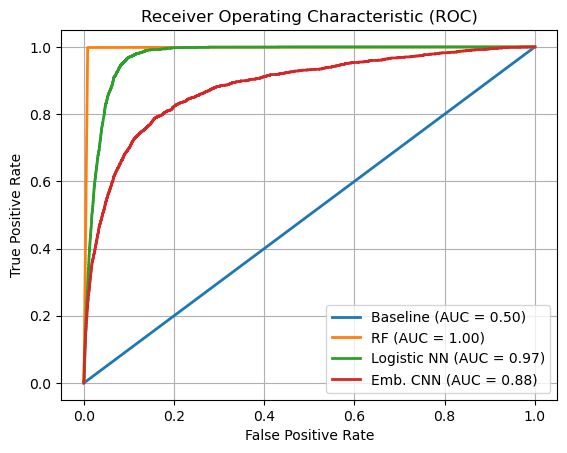

In [35]:
model1_best_pred = model1.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, model1_best_pred.ravel())
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'Baseline (AUC = {roc_auc:.2f})')

model2_best = RandomForestClassifier(n_estimators=64,
                                        n_jobs=-1,
                                        random_state=7,
                                        max_depth=64,
                                        verbose = 0)
model2_best.fit(X_train,
                y_train)
model2_best_pred = model2_best.predict(X_test)
print_val_test_acc('Random Forest', y_test, model2_best_pred)
fpr, tpr, thresholds = roc_curve(y_test, model2_best_pred.ravel())
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'RF (AUC = {roc_auc:.2f})')


model3_best = build_model3()
model3_best.fit(X_train,
           y_train,
           verbose=0)
model3_best_pred = model3_best.predict(X_test)
print_val_test_acc('Logistic NN', y_test, model3_best_pred)
fpr, tpr, thresholds = roc_curve(y_test, model3_best_pred.ravel())
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'Logistic NN (AUC = {roc_auc:.2f})')

model4_best = load_model(f'model4_500_20_0.01_1024')
model4_best_pred = model4_best.predict(encode_and_batch(X_test_embed, y_test, input_len=500, batch_size=1024))
print_val_test_acc('Emb. CNN', y_test, model4_best_pred)
fpr, tpr, thresholds = roc_curve(y_test, model4_best_pred.ravel())
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'Emb. CNN (AUC = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Classification Report

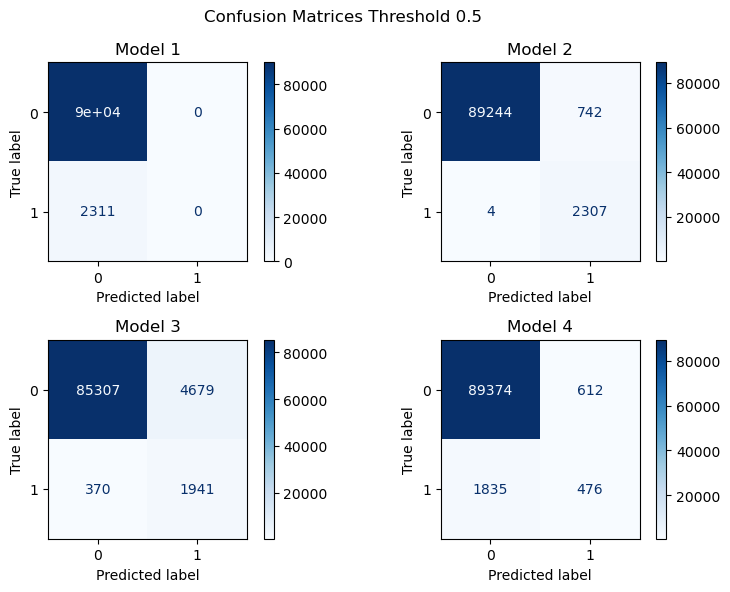

In [28]:

threshold = 0.5
# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
# Flatten axes for easy iteration
axes = axes.flatten()
for idx, y_pred in enumerate([model1_best_pred, model2_best_pred, (model3_best_pred >= threshold).astype(int), (model4_best_pred >= threshold).astype(int)]):
    y_outcome = (y_pred >= threshold).astype(int)  # convert to 0 or 1
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[idx], cmap=plt.cm.Blues)
    axes[idx].set_title(f'Model {idx+1}')
plt.suptitle(f'Confusion Matrices Threshold {threshold}')
plt.tight_layout()
plt.show()

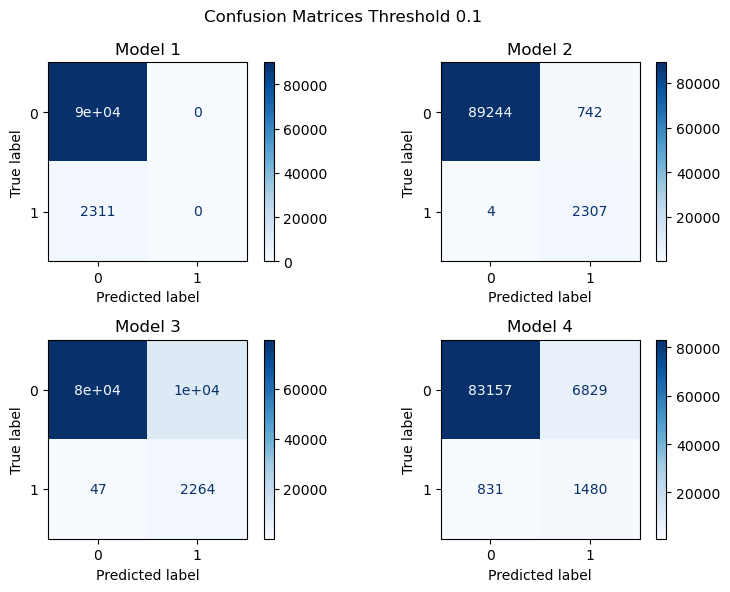

In [29]:

threshold = 0.1
# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
# Flatten axes for easy iteration
axes = axes.flatten()
for idx, y_pred in enumerate([model1_best_pred, model2_best_pred, (model3_best_pred >= threshold).astype(int), (model4_best_pred >= threshold).astype(int)]):
    y_outcome = (y_pred >= threshold).astype(int)  # convert to 0 or 1
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[idx], cmap=plt.cm.Blues)
    axes[idx].set_title(f'Model {idx+1}')
plt.suptitle(f'Confusion Matrices Threshold {threshold}')
plt.tight_layout()
plt.show()

### Subgroup Analysis

Model 2 - RandomForest, Model 4 - Embedding DNN

- channelGrouping - 8
- device_category - 3
- newVisits - binary
- country - bin as top 10 + other
- source - bin as top 10 + other

In [30]:
subgroups = [col for col in X_test.columns if col.startswith('device_category')]
y_true_group = y_test[(X_test[subgroups] == 0).all(axis=1)]
y_pred_group = model2_best_pred[(X_test[subgroups] == 0).all(axis=1)]
print_val_test_acc(f"Model 2 | country_firstGroup", y_true_group, y_pred_group)

Model 2 | country_firstGroup | 1 | 0.758 | 0.998 | 0.862 | 2108 


In [31]:

for feature in ['channelGrouping', 'device_category', 'source', 'country']:
    print(f"""
#### {feature}

Model|Subgroup|Class|Precision|Recall|f1-Score|Support
-|-|-|-|-|-|-""")
    subgroups = [col for col in X_test.columns if col.startswith(feature)]
    for group in subgroups:
        y_true_group = y_test[X_test[group] == 1]
        y_pred_group = model2_best_pred[X_test[group] == 1]
        if (sum(y_pred_group) > 0 and sum(y_true_group) > 0):
            print_val_test_acc(f"Model 2 | {group.split('_')[-1]}", y_true_group, y_pred_group)
        y_pred_group = model3_best_pred[X_test[group] == 1]
        if (sum(y_pred_group) > 0 and sum(y_true_group) > 0):
            print_val_test_acc(f"Model 3 | {group.split('_')[-1]}", y_true_group, y_pred_group)
        y_pred_group = model4_best_pred[X_test[group] == 1]
        if (sum(y_pred_group) > 0 and sum(y_true_group) > 0):
            print_val_test_acc(f"Model 4 | {group.split('_')[-1]}", y_true_group, y_pred_group)
    y_true_group = y_test[(X_test[subgroups] == 0).all(axis=1)]
    y_pred_group = model2_best_pred[(X_test[subgroups] == 0).all(axis=1)]
    if (sum(y_pred_group) > 0 and sum(y_true_group) > 0):
        print_val_test_acc(f"Model 2 | default", y_true_group, y_pred_group)
    y_pred_group = model3_best_pred[(X_test[subgroups] == 0).all(axis=1)]
    if (sum(y_pred_group) > 0 and sum(y_true_group) > 0):
        print_val_test_acc(f"Model 3 | default", y_true_group, y_pred_group)
    y_pred_group = model4_best_pred[(X_test[subgroups] == 0).all(axis=1)]
    if (sum(y_pred_group) > 0 and sum(y_true_group) > 0):
        print_val_test_acc(f"Model 4 | default", y_true_group, y_pred_group)



#### channelGrouping

Model|Subgroup|Class|Precision|Recall|f1-Score|Support
-|-|-|-|-|-|-
Model 2 | Affiliates | 1 | 1.000 | 1.000 | 1.000 | 3 
Model 3 | Affiliates | 1 | 0.200 | 0.667 | 0.308 | 3 
Model 4 | Affiliates | 1 | 0.167 | 0.333 | 0.222 | 3 
Model 2 | Direct | 1 | 0.743 | 1.000 | 0.852 | 384 
Model 3 | Direct | 1 | 0.268 | 0.831 | 0.406 | 384 
Model 4 | Direct | 1 | 0.361 | 0.253 | 0.297 | 384 
Model 2 | Display | 1 | 0.846 | 1.000 | 0.917 | 22 
Model 3 | Display | 1 | 0.306 | 0.864 | 0.452 | 22 
Model 4 | Display | 1 | 0.667 | 0.182 | 0.286 | 22 
Model 2 | Organic Search | 1 | 0.736 | 0.997 | 0.847 | 709 
Model 3 | Organic Search | 1 | 0.245 | 0.767 | 0.372 | 709 
Model 4 | Organic Search | 1 | 0.338 | 0.186 | 0.240 | 709 
Model 2 | Paid Search | 1 | 0.845 | 1.000 | 0.916 | 87 
Model 3 | Paid Search | 1 | 0.203 | 0.839 | 0.327 | 87 
Model 4 | Paid Search | 1 | 0.419 | 0.149 | 0.220 | 87 
Model 2 | Referral | 1 | 0.768 | 0.998 | 0.868 | 1085 
Model 3 | Referral | 1 | 0.356 

### Word Cloud

Find biggest product name associated with converted_session.  Subgroup on the biggest names and check model metrics


Text(0.5, 1.0, 'Word cloud for productName')

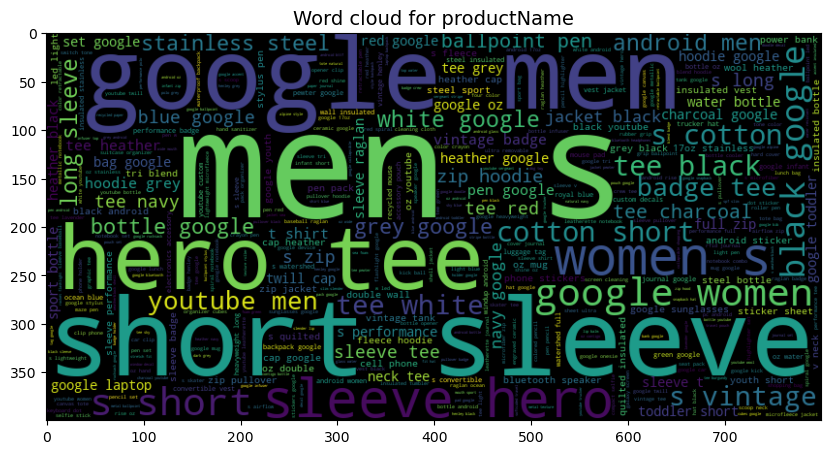

In [32]:

df_conversion = X_train_embed[y_train_embed == 1]
plt.figure(figsize = (10,10))
wc = WordCloud(
    max_words = 500,
    width = 800,
    height = 400).generate(" ".join(df_conversion['productName']))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for productName',fontsize=14)


In [36]:
top_product_names = [
    ["google", "men", "hero", "tee"],
    ["short", "sleeve"],
    ["s", "vintage"],
    ["cotton", "short"],
    ["google"],
    ["short"],
    ["google", "men", "hero", "tee", "short", "sleeve", "s", "vintage", "cotton"],

]

print(f"""
#### Popular Product Name Combo

Model|Subgroup|Class|Precision|Recall|f1-Score|Support
-|-|-|-|-|-|-""")
# Create regex pattern: "shoes|shirt"
for keywords in top_product_names:
# Filter rows where productName contains *all* keywords
    mask = X_test_embed['productName'].str.contains(keywords[0], case=False, na=False)
    for word in keywords[1:]:
        mask &= X_test_embed['productName'].str.contains(word, case=False, na=False)

    y_true_group = y_test_embed[mask]
    y_pred_group = model4_pred[mask]
    if (len(y_pred_group) > 0 and len(y_true_group) > 0):
        print_val_test_acc(f"Model 4 | {keywords}", y_true_group, y_pred_group)



#### Popular Product Name Combo

Model|Subgroup|Class|Precision|Recall|f1-Score|Support
-|-|-|-|-|-|-
Model 4 | ['google', 'men', 'hero', 'tee'] | 1 | 0.032 | 0.011 | 0.017 | 1567 
Model 4 | ['short', 'sleeve'] | 1 | 0.028 | 0.012 | 0.016 | 1729 
Model 4 | ['s', 'vintage'] | 1 | 0.028 | 0.012 | 0.017 | 1045 
Model 4 | ['cotton', 'short'] | 1 | 0.036 | 0.013 | 0.019 | 1233 
Model 4 | ['google'] | 1 | 0.025 | 0.010 | 0.015 | 2226 
Model 4 | ['short'] | 1 | 0.028 | 0.012 | 0.016 | 1729 
Model 4 | ['google', 'men', 'hero', 'tee', 'short', 'sleeve', 's', 'vintage', 'cotton'] | 1 | 0.040 | 0.012 | 0.019 | 817 
